## PREPROCESSING

### Imports

In [24]:
import pandas as pd
import numpy as np
import re, spacy, unidecode, warnings, itertools
from tqdm import tqdm, tqdm_notebook
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from label_cleaning import label_cleaning

In [2]:
warnings.filterwarnings('ignore')
nlp = spacy.load("fr_core_news_md")
tqdm.pandas(tqdm_notebook)

### Database loading

In [3]:
%%time
df = pd.read_pickle('../data/data.pkl')

CPU times: user 1.48 s, sys: 762 ms, total: 2.25 s
Wall time: 3.04 s


### Preprocessing

#### Labels

In [1]:
def preprocessing_label(text):
    text = re.sub(r"(\w)([A-Z][a-z])", r"\1 \2", text)
    text = text.split('\n\n')
    text = [word.split(' - ') for word in text]
    text = [word.strip().lower() for word in itertools.chain.from_iterable(text) if word != '']
    text = [re.sub('null*', '', word).strip() for word in text]
    text = [re.sub('\n*', '', word).strip() for word in text]
    text = [re.sub('jdf*', '', word).strip() for word in text]
    text = [unidecode.unidecode(word) for word in text if word != '']
    return text

In [5]:
df['labels'] = df.SCT[df.SCT.notnull()].progress_map(preprocessing_label)

100%|██████████| 17098/17098 [00:01<00:00, 10004.88it/s]


#### Main labels

In [6]:
def preprocessing_main_label(text):
    try:
        return text[0].split(',')[0]
    except:
        return np.NaN

In [7]:
df['main_labels'] = df.labels[df.labels.notnull()].progress_map(preprocessing_main_label)

100%|██████████| 17098/17098 [00:00<00:00, 423187.56it/s]


In [8]:
label_remove = list(df.main_labels.value_counts()[df.main_labels.value_counts() < 3].index)

In [9]:
def preprocessing_main_label_2(text):
    if text in label_remove:
        return np.NaN
    else:
        return text

In [10]:
df['main_labels'] = df.main_labels[df.main_labels.notnull()].progress_map(preprocessing_main_label_2)

100%|██████████| 17097/17097 [00:00<00:00, 149923.41it/s]


In [11]:
df['main_labels'].nunique()

311

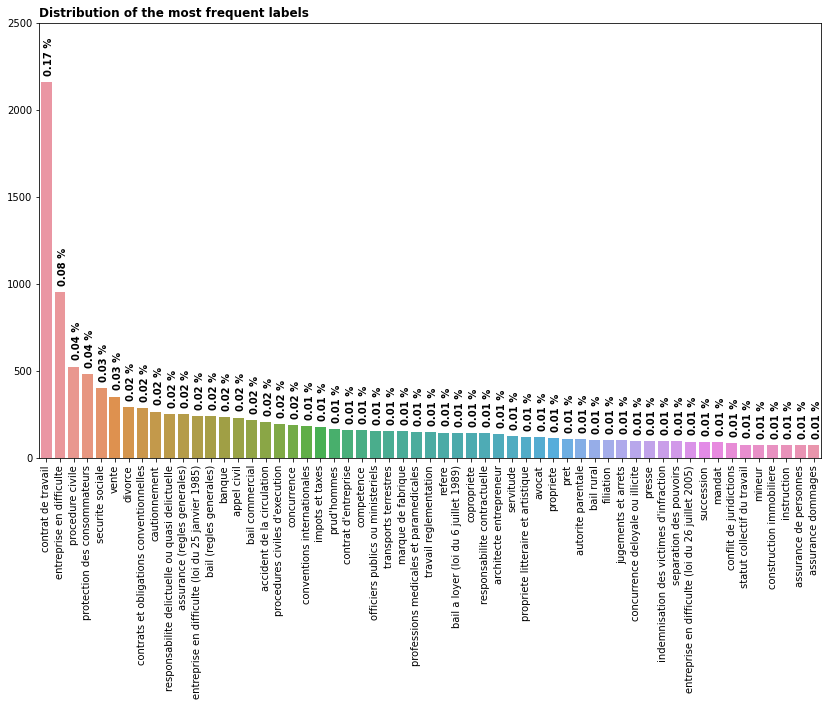

In [12]:
labels_counts = df.main_labels[df.main_labels.notnull()].value_counts()[df.main_labels[df.main_labels.notnull()].value_counts() > 70]
plt.figure(figsize = (14, 8))

sns.barplot(x = labels_counts.index, y = labels_counts.values)
for i in range(len(labels_counts)):
    plt.text(x = i - 0.15, 
             y = labels_counts.values[i] + 50,
             s = f'{round(labels_counts.values[i]/labels_counts.sum(), 2)} %',
             fontweight = 'bold',
             rotation = 90)
plt.xticks(rotation = 90)
plt.gca().set_ylim([0, 2500])
plt.title('Distribution of the most frequent labels', fontweight = 'bold', loc = 'left')
plt.show()

#### Texts

In [13]:
def preprocessing_text(text):
    text = re.sub('\W', ' ', text).lower().split()
    text = [unidecode.unidecode(word.strip()) for word in text if len(word) > 2]
    text = [word for word in text if not nlp.vocab[word].is_stop and word != 'null']
    text = [text[i] for i in range(len(text)) if text[i].isalpha() or text[i - 1] == 'article']
    return text

In [14]:
df['tokens'] = df.CONTENU.progress_map(preprocessing_text)

100%|██████████| 67210/67210 [06:38<00:00, 168.65it/s]


In [15]:
def freq_counter(corpus):
    lenght = 0
    unique_words = list()
    for text in tqdm(corpus):
        lenght += len(text)
        unique_words += list(set(text))
    print(f'Number of words in the corpus: {lenght}',
          f'\nNumber of unique words in the corpus: {len(unique_words)}')
    return Counter(unique_words)

In [16]:
counter_corpus = freq_counter(df.tokens)

100%|██████████| 67210/67210 [00:15<00:00, 4430.06it/s]


Number of words in the corpus: 64950899 
Number of unique words in the corpus: 28343648


In [17]:
64950899 / len(df)

966.3874274661508

In [18]:
most_common_words_per_freq = [(word, round(count/len(df), 2)) for (word, count) in tqdm(counter_corpus.most_common())]

100%|██████████| 231398/231398 [00:00<00:00, 413344.33it/s]


In [19]:
less_frequent_words = [word for (word, count) in counter_corpus.most_common() if count == 1 and word.isalpha()]
most_frequent_words = [word for (word, count) in most_common_words_per_freq if count > 0.5 and word.isalpha()]

In [20]:
len(most_frequent_words), len(less_frequent_words)

(98, 109922)

In [25]:
def preprocessing_text_2(text):
    text = np.array(text)
    text = text[np.isin(text, less_frequent_words, invert = True)]
    text = text[np.isin(text, most_frequent_words, invert = True)]
    return text

In [31]:
df['tokens_rest'] = df.tokens.progress_map(preprocessing_text_2)

100%|██████████| 67210/67210 [4:50:40<00:00,  3.85it/s]  


In [37]:
counter_corpus_2 = freq_counter(df.tokens_rest)

100%|██████████| 67210/67210 [00:54<00:00, 1233.63it/s]


Number of words in the corpus: 46424975 
Number of unique words in the corpus: 23492442


In [26]:
df = pd.read_pickle('../data/preprocessing.pkl')

In [38]:
46424975 / len(df)

690.7450528195209

In [9]:
distribution_length_words = [len(i) for i in df.tokens_rest]

In [ ]:
plt.figure(figsize = (10, 5))
sns.distplot(df.tokens_rest.str.len(), hist = False)
plt.yticks([])
plt.title('Distribution of text lenghts', loc = 'left', fontweight = 'bold')
plt.show()

In [ ]:
df.tokens_rest.str.len().describe()

In [62]:
corpus = list()
for text in tqdm(df.tokens_rest):
    for word in text:
        corpus.append(word)
        
corpus = ' '.join(corpus)

100%|██████████| 67210/67210 [00:36<00:00, 1850.01it/s]


In [ ]:
%%time
wordcloud = WordCloud(width=800, height=400,max_font_size=70, max_words=100,
                      background_color="white").generate(corpus)

In [ ]:
plt.figure(figsize = (10, 15))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()